# WSI - ćwiczenie 7
## Modele bayesowskie
## Yaroslav Harbar

Celem siódmego ćwiczenia jest zaimplementowanie naiwnego klasyfikatora Bayesa. Dodatkowo trzeba wykorzystać stworzony algorytm do stworzenia zbadania jakości klasyfikatorów dla zbioru danych Cardio Vascular Disease Detection.

# Importowanie bibliotek

In [442]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

# Przygotowanie danych

In [443]:
np.seterr(divide='ignore')
plt.rcParams.update({'font.size': 18})

dataset = pd.read_csv("./cardio_train.csv", sep=';')
dataset.drop(["id"], axis=1, inplace=True)
dataset.dropna(inplace=True)

In [444]:
dataset.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,23393,1,155,62.0,120,80,1,1,0,0,1,0


# Implementacja naiwnego klasyfikatora Bayessa
Naiwny klasyfikator Bayessa bazuje się na twierdzeniu Bayessa. Proces klasyfikacji odbywa się poprzez obliczenie a posteriori dla wszystkich klas przy danych bieżących na podstawie wiedzy a priori, którą posiadamy z wcześniejszych obserwacji.

In [445]:
class NaiveBayes:
    def __init__(self):
        self.classes = None
        self.mean = None
        self.var = None
        self.priors = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        class_count = len(self.classes)

        self.mean = np.zeros((class_count, n_features))
        self.var = np.zeros((class_count, n_features))
        self.priors = np.zeros(class_count)

        for index, c in enumerate(self.classes):
            X_c = X[y == c]
            self.mean[index, :] = X_c.mean(axis=0)
            self.var[index, :] = X_c.var(axis=0)
            self.priors[index] = X_c.shape[0] / n_samples

    def predict(self, X):
        return np.array([self.get_class_highest_posterior(x) for x in X])

    def get_class_highest_posterior(self, X):
        posteriors = []

        for index, c in enumerate(self.classes):
            prior = np.log(self.priors[index])

            a = self.get_class_gaussian_probability(index, X)
            posterior = np.sum(np.log(a))
            posterior = posterior + prior

            posteriors.append(posterior)

        return self.classes[np.argmax(posteriors)]

    def get_class_gaussian_probability(self, class_index, x):
        mean = self.mean[class_index]
        var = self.var[class_index]

        return (np.exp(-((x - mean) ** 2) / (2 * var))) / (np.sqrt(2 * np.pi * var))

Klasa, która pomaga w tworzeniu macierzy pomyłek

In [446]:
class ConfusionMatrix:
    def __init__(self):
        self.confusion_matrix_data_frame = pd.DataFrame()
        self.confusion_matrix = None
        self.precision = None
        self.sensitivity = None
        self.accuracy = None
        self.f1_score = None

    def set_metrics(self, y_real, y_predicted):
        self.confusion_matrix = metrics.confusion_matrix(y_real, y_predicted)

        class_names = list(set(y_real))

        confusion_matrix_data_frame = pd.DataFrame(self.confusion_matrix, index=class_names, columns=class_names)

        TN = self.confusion_matrix[0, 0]
        FP = self.confusion_matrix[0, 1]
        FN = self.confusion_matrix[1, 0]
        TP = self.confusion_matrix[1, 1]

        self.precision = TP / (TP + FP)
        self.sensitivity = TP / (TP + FN)
        self.accuracy = (TP + TN) / (TP + TN + FP + FN)
        self.f1_score = 2 * (self.precision * self.sensitivity) / (self.precision + self.sensitivity)


        self.confusion_matrix_data_frame = confusion_matrix_data_frame

    def get_metrics(self):
        return [
            self.precision,
            self.sensitivity,
            self.accuracy,
            self.f1_score
        ]

    def print_metrics(self):
        print("Precision: ", self.precision)
        print("Sensitivity: ", self.sensitivity)
        print("Accuracy: ", self.accuracy)
        print("F1 score: ", self.f1_score)

    def draw_confusion_matrix(self):
        if not self.confusion_matrix_data_frame.empty:
            plt.figure(figsize=(8, 6))

            group_names = ["TN", "FP", "FN", "TP"]
            group_counts = ["{0:0.0f}".format(value) for value in self.confusion_matrix.flatten()]
            group_percentages = ["{0:.2%}".format(value) for value in self.confusion_matrix.flatten()/np.sum(self.confusion_matrix)]

            labels = [f"{l1}\n{l2}\n{l3}" for l1, l2, l3 in zip(group_names,group_counts,group_percentages)]
            labels = np.asarray(labels).reshape(2,2)

            heatmap = sns.heatmap(self.confusion_matrix_data_frame, annot=labels, cmap="Blues", fmt='')
            heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
            heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')

            plt.ylabel('Actual label')
            plt.xlabel('Predicted label')
            plt.title('Confusion Matrix')

            plt.show()

Dodatkowo stworzyłem klasę, która pomaga w przeprowadzeniu symulacji oraz badanu wpływu podziału zbioru danych na wynik klasyfikacji. W środku tej klasy jest zaimplementowana funkcja **simulate**, której zadaniem jest symulowanie modelu klasyfikacji opartego na algorytmie Naive Bayes. Ona przyjmuję 4 argumenty:
- train_test_proportion - proporcja danych używana do treningu i testowania modelu (trenowania w przypadku walidacji krzyżowej),
- train_valid_proportion - proporcja danych używana do treningu i walidacji modelu (trenowania z użyciem zwykłej walidacji),
- cross_validation - czy używać krzyżowej walidacji (parametr odpowiadający czy używać krzyżowej walidacji),
- cross_validation_proportion - ilość podziałów danych w krzyżowej walidacji (ilość podziałów danych w krzyżowej walidacji).

Podczas walidacji krzyżowej bierzemy średni wynik ze wszystkich podzbiorów i następnie wynik na zbiorze testowym algorytm mierzy modelem wytrenowanym na całym zbiorze trenującym

In [447]:
class Simulation:
    def __init__(self, dataset):
        self.dataset = dataset
        self.simulation_list = []

    def get_parametrs(self):
        return [
            self.simulation_list,
        ]

    def simulate(self, train_test_proportion, train_valid_proportion, cross_validation=False, cross_validation_proportion=5):
        nb = NaiveBayes()
        cm = ConfusionMatrix()

        self.dataset.dropna(inplace=True)

        clean_y = self.dataset["cardio"]
        clean_X = self.dataset.drop(["cardio"], axis=1)

        X_train, X_test, y_train, y_test = train_test_split(clean_X, clean_y, train_size=train_test_proportion)

        accuracy =  0
        precision = 0
        sensitivity = 0
        f1_score = 0

        if cross_validation:
            print("-------Cross Validation-------")
            kf = KFold(n_splits=cross_validation_proportion, random_state=None, shuffle=False)

            i = 0

            for train_index, test_index in kf.split(X_train):
                i += 1
                print(f'Cross Validation #{i}')

                X_set_train, X_set_valid = X_train.iloc[train_index].values, X_train.iloc[test_index].values
                y_set_train, y_set_valid = y_train.iloc[train_index].values, y_train.iloc[test_index].values

                nb.fit(X_set_train, y_set_train)
                validation_predictions = nb.predict(X_set_valid)

                cm.set_metrics(y_set_valid, validation_predictions)
                cm.print_metrics()
                cm.draw_confusion_matrix()

                accuracy += cm.accuracy
                precision += cm.precision
                sensitivity += cm.sensitivity
                f1_score += cm.f1_score

            accuracy /= i
            precision /= i
            sensitivity /= i
            f1_score /= i

            self.simulation_list.append(["Cross Validation", train_test_proportion, cross_validation_proportion, 1 - train_test_proportion, accuracy, precision, sensitivity, f1_score])
            nb.fit(X_train, y_train)

        else:
            X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=train_valid_proportion)

            nb.fit(X_train, y_train)
            validation_predictions = nb.predict(X_valid.to_numpy())

            cm.set_metrics(y_valid, validation_predictions)
            cm.print_metrics()
            cm.draw_confusion_matrix()

            self.simulation_list.append(["Validation", train_test_proportion * train_valid_proportion, train_test_proportion * (1 - train_valid_proportion), 1 - train_test_proportion, cm.accuracy, cm.precision, cm.sensitivity, cm.f1_score])

        print("-------Testing-------")

        test_predictions = nb.predict(X_test.to_numpy())

        cm.set_metrics(y_test, test_predictions)
        cm.print_metrics()
        cm.draw_confusion_matrix()

        if cross_validation:
            self.simulation_list.append(["Testing", train_test_proportion, cross_validation_proportion, 1 - train_test_proportion, cm.accuracy, cm.precision, cm.sensitivity, cm.f1_score])
        else:
            self.simulation_list.append(["Testing", train_test_proportion * train_valid_proportion, train_test_proportion * (1 - train_valid_proportion), 1 - train_test_proportion, cm.accuracy, cm.precision, cm.sensitivity, cm.f1_score])

    def get_simulation_table(self):
        return pd.DataFrame(self.simulation_list, columns=["action", "train proportion", "validation/cross validation proportion", "test proportion", "accuracy", "precision", "sensitivity", "f1 score"])

    def sub_simulation_columns(self):
        df = self.get_simulation_table()
        even_rows = df.iloc[::2]
        even_rows.drop(["action"], axis=1, inplace=True)

        even_rows['accuracy'] = df['accuracy'].values[1::2] - df['accuracy'].values[::2]
        even_rows['precision'] = df['precision'].values[1::2] - df['precision'].values[::2]
        even_rows['sensitivity'] = df['sensitivity'].values[1::2] - df['sensitivity'].values[::2]
        even_rows['f1 score'] = df['f1 score'].values[1::2] - df['f1 score'].values[::2]

        return even_rows

# Zastosowanie algorytmu
Na początku badam wpływ wartości proporcji na jakość modelu przy użyciu zwykłej walidacji

Precision:  0.7292863002461034
Sensitivity:  0.28502725232446297
Accuracy:  0.5895462562129229
F1 score:  0.4098662978331028


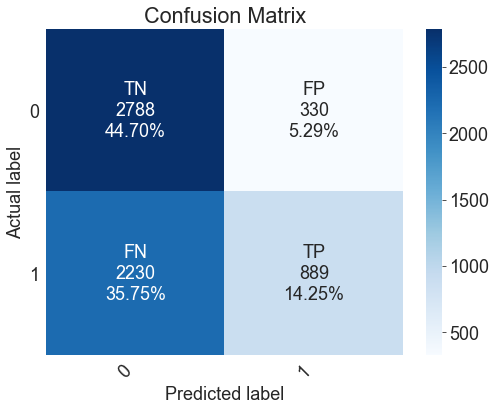

-------Testing-------
Precision:  0.7182280319535221
Sensitivity:  0.28378766140602585
Accuracy:  0.58389842735536
F1 score:  0.40682846565199504


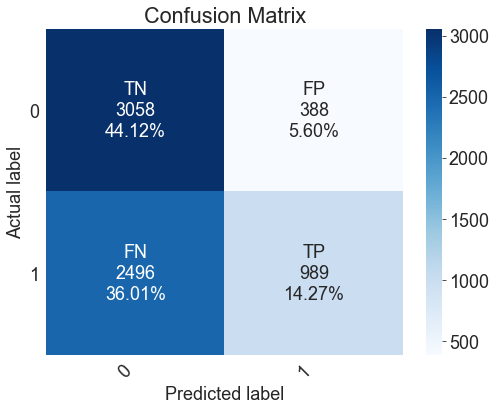

In [448]:
simulation_simple_validation = Simulation(dataset)
simulation_simple_validation.simulate(0.9, 0.9)

Zmniejszę zbiór trenujący i zwiększę zbiór walidacyjny. Zbiór testowy zostaje taki sam

Precision:  0.7145911277391769
Sensitivity:  0.2865716429107277
Accuracy:  0.5871412538079205
F1 score:  0.4090874321119865


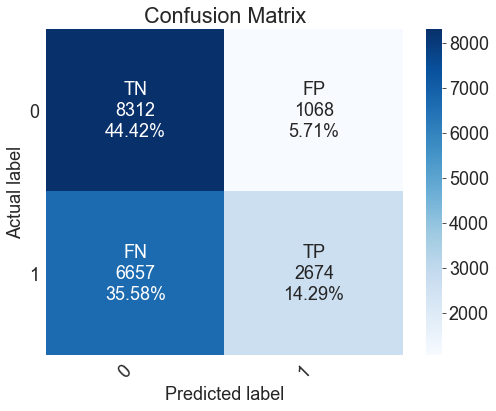

-------Testing-------
Precision:  0.733044733044733
Sensitivity:  0.29466357308584684
Accuracy:  0.5957293319867263
F1 score:  0.42035581299131153


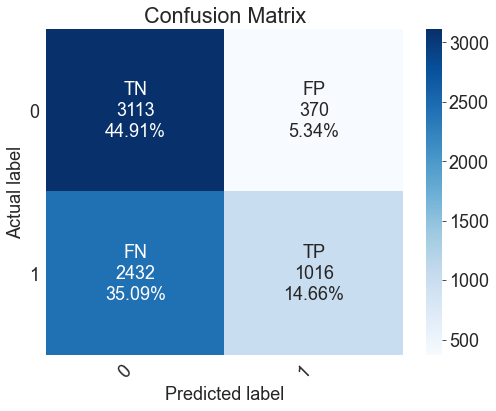

In [449]:
simulation_simple_validation.simulate(0.9, 0.7)

Precision:  0.7248347497639283
Sensitivity:  0.24791680124022997
Accuracy:  0.5799262465929133
F1 score:  0.36946476703889103


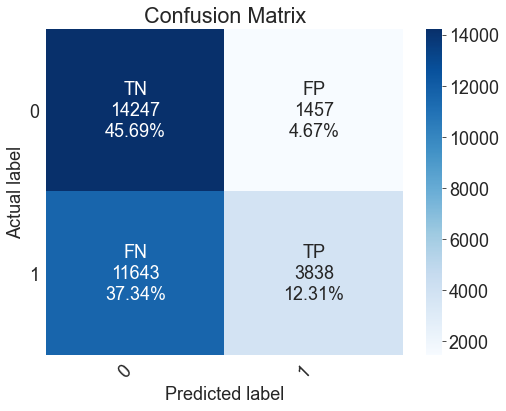

-------Testing-------
Precision:  0.7583834909716252
Sensitivity:  0.25221618530168716
Accuracy:  0.5821670754580869
F1 score:  0.3785407725321889


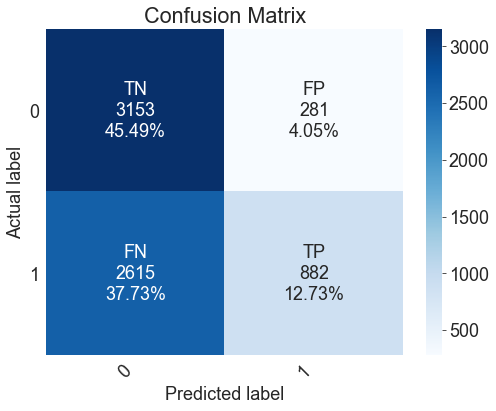

In [450]:
simulation_simple_validation.simulate(0.9, 0.5)

Zmniejszam zbiór trenujący, zwiększając zbiór walidacyjny oraz zbiór testowy

Precision:  0.668074902945878
Sensitivity:  0.5134708205353226
Accuracy:  0.6304604486422668
F1 score:  0.5806579665558478


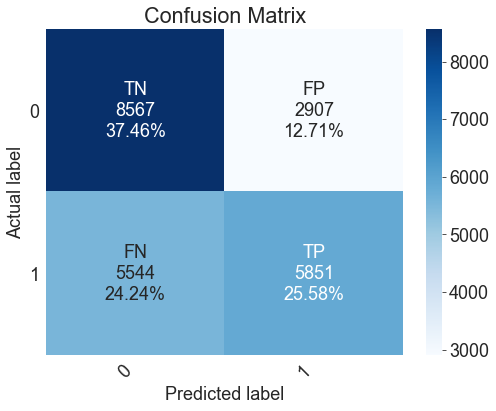

-------Testing-------
Precision:  0.6800044213551454
Sensitivity:  0.5217981340118745
Accuracy:  0.6378644484997665
F1 score:  0.5904880740989586


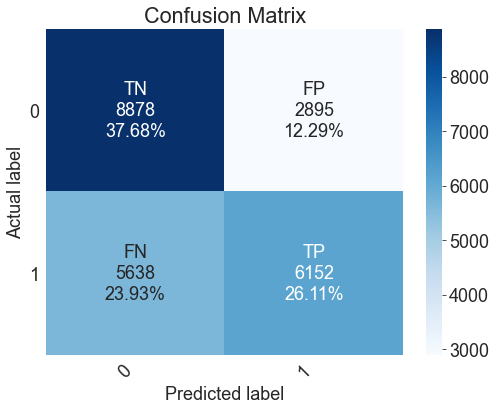

In [451]:
simulation_simple_validation.simulate(0.66, 0.5)

Precision:  0.7324574499850701
Sensitivity:  0.28563111318118306
Accuracy:  0.5941702741702741
F1 score:  0.4109910362737706


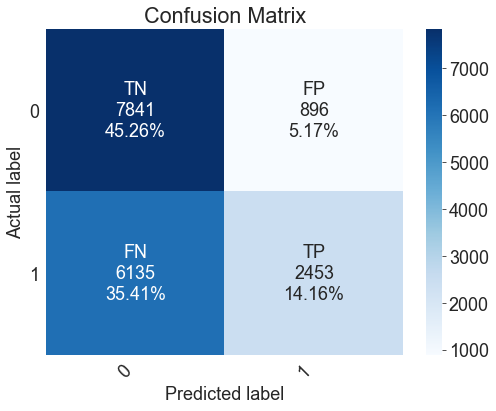

-------Testing-------
Precision:  0.7228513356562137
Sensitivity:  0.2876372039283651
Accuracy:  0.5890450492049292
F1 score:  0.41152161335647575


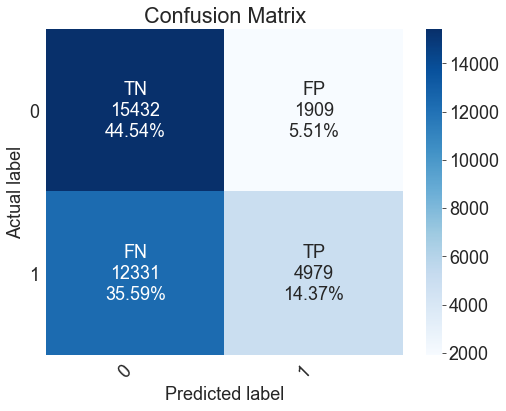

In [452]:
simulation_simple_validation.simulate(0.5, 0.5)

Precision:  0.7357363542739443
Sensitivity:  0.3232871753099828
Accuracy:  0.604978354978355
F1 score:  0.4491951710261569


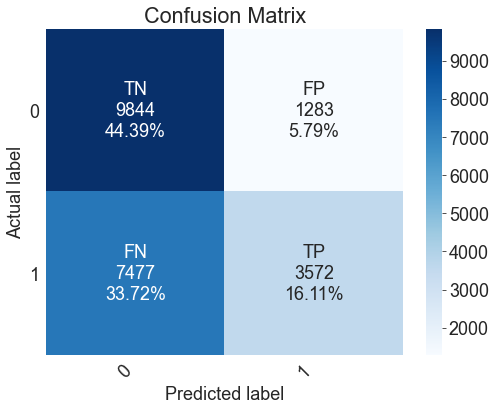

-------Testing-------
Precision:  0.7276107510889196
Sensitivity:  0.3299768741568703
Accuracy:  0.6038815805295688
F1 score:  0.45404222877788464


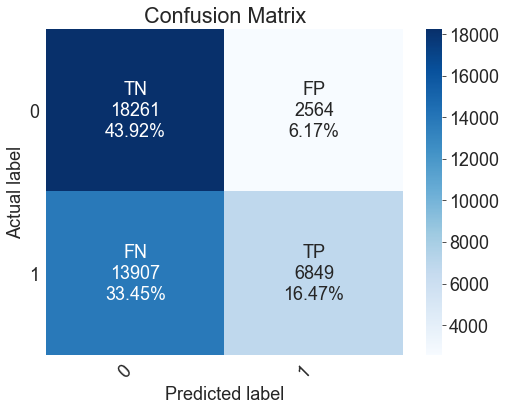

In [453]:
simulation_simple_validation.simulate(0.4, 0.2)

In [454]:
simulation_simple_validation.get_simulation_table()

,action,train proportion,validation/cross validation proportion,test proportion,accuracy,precision,sensitivity,f1 score
0,Validation,0.81,0.09,0.10,0.589546,0.729286,0.285027,0.409866
1,Testing,0.81,0.09,0.10,0.583898,0.718228,0.283788,0.406828
2,Validation,0.63,0.27,0.10,0.587141,0.714591,0.286572,0.409087
3,Testing,0.63,0.27,0.10,0.595729,0.733045,0.294664,0.420356
4,Validation,0.45,0.45,0.10,0.579926,0.724835,0.247917,0.369465
5,Testing,0.45,0.45,0.10,0.582167,0.758383,0.252216,0.378541
6,Validation,0.33,0.33,0.34,0.630460,0.668075,0.513471,0.580658
7,Testing,0.33,0.33,0.34,0.637864,0.680004,0.521798,0.590488
8,Validation,0.25,0.25,0.50,0.594170,0.732457,0.285631,0.410991
9,Testing,0.25,0.25,0.50,0.589045,0.722851,0.287637,0.411522


Po kilkokrotnej symulacji otrzymałem takie wyniki, że dość ciężko określić jaki podziałał daje najlepsze wyniki. Wartość F1 maleje przy zmniejszeniu zbioru trenującego. Natomiast dla małego zbioru trenującego (zaczynając od tego że zbiór trenujący jest 25% od całego zbioru danych) wartość F1 w tym przypadku wzrosła, ale po kilkakrotnym uruchomieniu symulacji z takim podziałem wynik F1 dawał wartości w zakresie od **0,25** do **0,62**, gdzie najczęściej występowała wartość w okolicach **0,39**. W przypadku dużego zbioru trenującego wynik F1 przyjmował wartości od **0,39** do **0,44**. Więc średnio możemy powiedzieć, że duży zbiór trenujący daje lepszy wyniki. Dodatkowo można porównać wyniki uzyskane po walidacji oraz testowaniu. Na tabelce, zamieszczonej poniżej widać, że różnica pomiędzy dokładnością i wynikiem F1 są dość małe i minimalnie się różnią w zależności od podziału.

In [455]:
simulation_simple_validation.sub_simulation_columns()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-447-ac2396cae44a>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  even_rows['accuracy'] = df['accuracy'].values[1::2] - df['accuracy'].values[::2]
<ipython-input-447-ac2396cae44a>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,train proportion,validation/cross validation proportion,test proportion,accuracy,precision,sensitivity,f1 score
0,0.81,0.09,0.10,-0.005648,-0.011058,-0.001240,-0.003038
2,0.63,0.27,0.10,0.008588,0.018454,0.008092,0.011268
4,0.45,0.45,0.10,0.002241,0.033549,0.004299,0.009076
6,0.33,0.33,0.34,0.007404,0.011930,0.008327,0.009830
8,0.25,0.25,0.50,-0.005125,-0.009606,0.002006,0.000531
10,0.08,0.32,0.60,-0.001097,-0.008126,0.006690,0.004847


Następnie badam wpływ wartości proporcji na jakość modelu przy użyciu walidacji krzyżowej.
Na początku sprawdzam jaki podział na sploty jest najlepszy. Zaczynając od podziału na 2 części

-------Cross Validation-------
Cross Validation #1
Precision:  0.7037668985431159
Sensitivity:  0.3444908448442017
Accuracy:  0.6004489337822672
F1 score:  0.46256038647342995


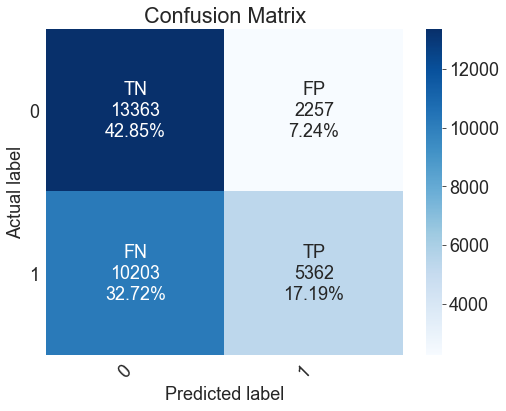

Cross Validation #2
Precision:  0.7409506398537478
Sensitivity:  0.2587461695607763
Accuracy:  0.5822350489017156
F1 score:  0.3835525693195798


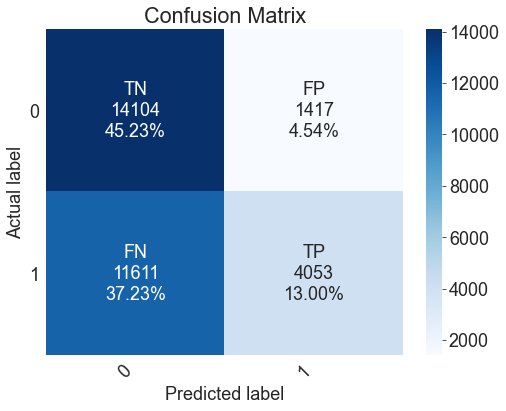

-------Testing-------
Precision:  0.7281410727406319
Sensitivity:  0.2920719127615679
Accuracy:  0.6000577117299091
F1 score:  0.41691207404291125


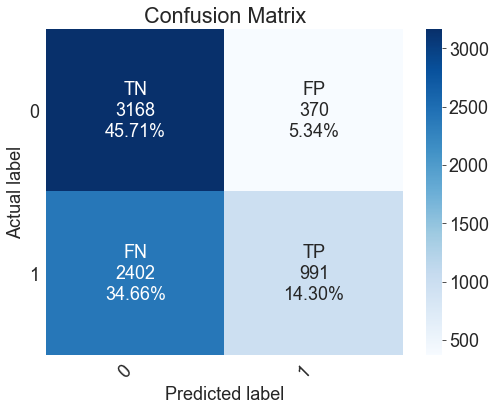

In [456]:
simulation_cross_validation = Simulation(dataset)
simulation_cross_validation.simulate(0.9, None, cross_validation=True, cross_validation_proportion=2)

-------Cross Validation-------
Cross Validation #1
Precision:  0.7261204164780444
Sensitivity:  0.2622629169391759
Accuracy:  0.5897867564534232
F1 score:  0.3853453453453453


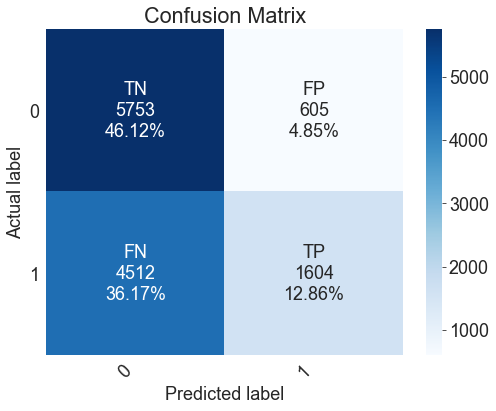

Cross Validation #2
Precision:  0.7226575809199318
Sensitivity:  0.33677357891394094
Accuracy:  0.5998877665544332
F1 score:  0.4594389689158453


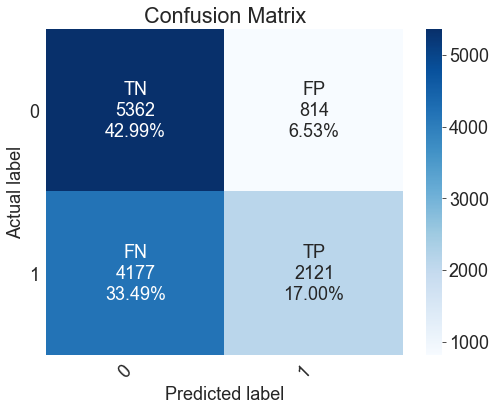

Cross Validation #3
Precision:  0.7258671124111993
Sensitivity:  0.2769010043041607
Accuracy:  0.5837742504409171
F1 score:  0.40087699053773374


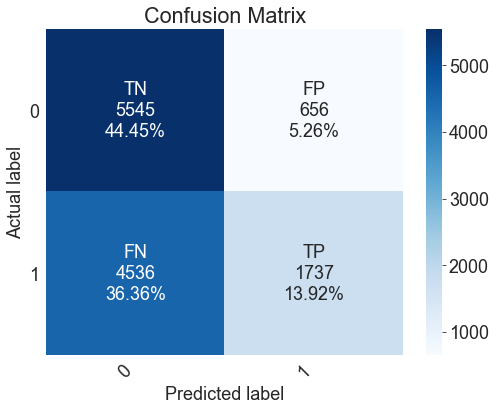

Cross Validation #4
Precision:  0.7095435684647303
Sensitivity:  0.3025575036191089
Accuracy:  0.5906685906685907
F1 score:  0.42422192151556154


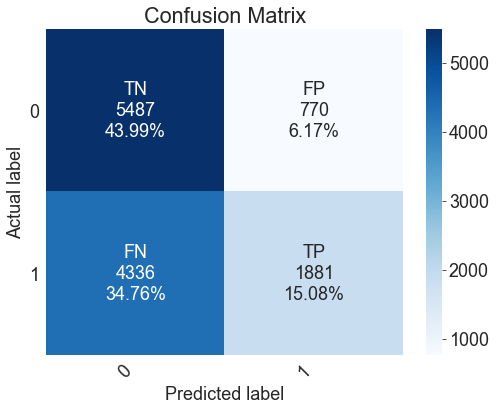

Cross Validation #5
Precision:  0.7194705380017079
Sensitivity:  0.27212532299741604
Accuracy:  0.5860189193522527
F1 score:  0.3948910241387391


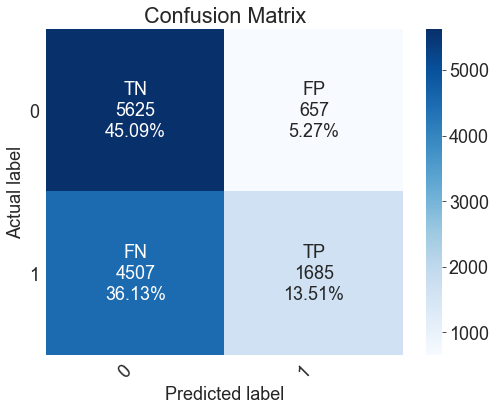

-------Testing-------
Precision:  0.7277335264301231
Sensitivity:  0.2850255246738514
Accuracy:  0.5820227961333141
F1 score:  0.409618911758712


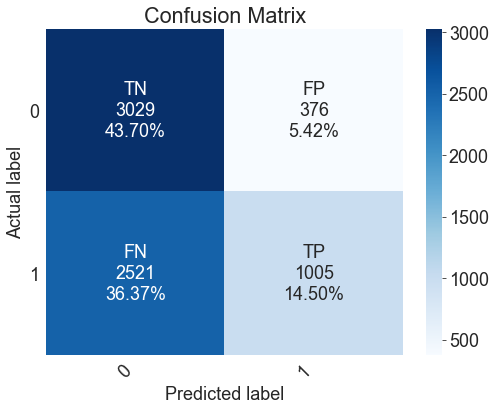

In [457]:
simulation_cross_validation.simulate(0.9, None, cross_validation=True, cross_validation_proportion=5)

-------Cross Validation-------
Cross Validation #1
Precision:  0.7140575079872205
Sensitivity:  0.2858056265984655
Accuracy:  0.5844155844155844
F1 score:  0.40821917808219177


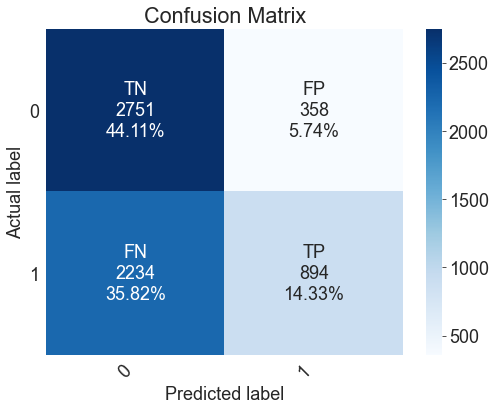

Cross Validation #2
Precision:  0.7083641746854182
Sensitivity:  0.31335952848722987
Accuracy:  0.6006092672759339
F1 score:  0.4345062429057889


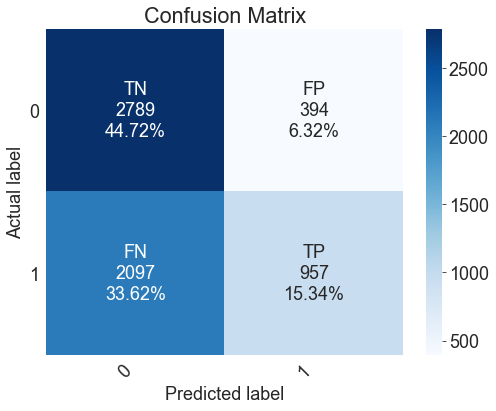

Cross Validation #3
Precision:  0.74
Sensitivity:  0.2847066367425457
Accuracy:  0.592271925605259
F1 score:  0.4112062977541098


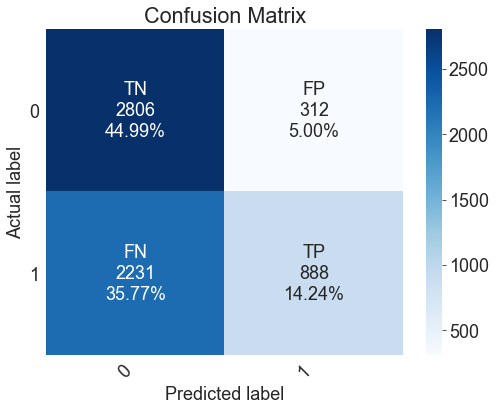

Cross Validation #4
Precision:  0.7068713450292398
Sensitivity:  0.31294498381877023
Accuracy:  0.5953182619849287
F1 score:  0.4338268281740691


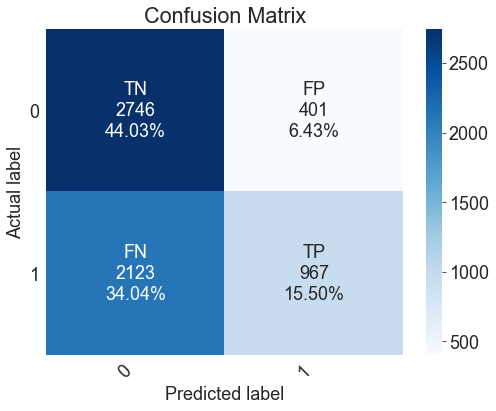

Cross Validation #5
Precision:  0.7317436661698957
Sensitivity:  0.32039151712887437
Accuracy:  0.6083052749719416
F1 score:  0.4456546403449058


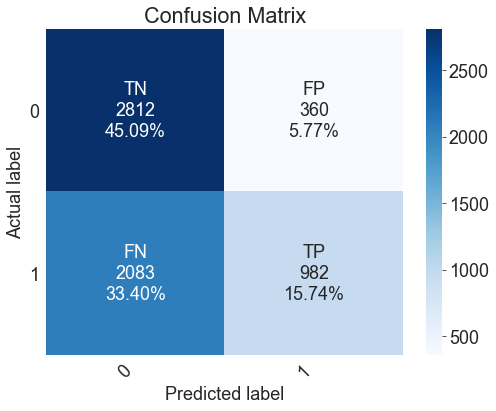

Cross Validation #6
Precision:  0.732
Sensitivity:  0.2903840050777531
Accuracy:  0.5877825877825877
F1 score:  0.4158145875937287


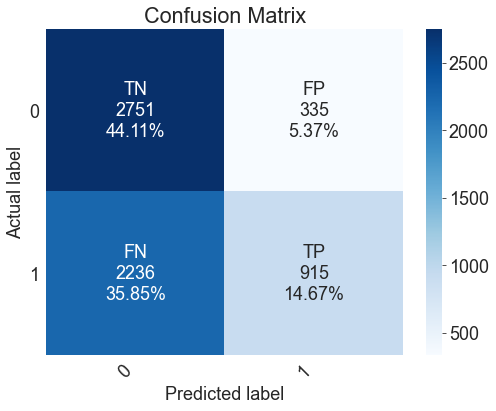

Cross Validation #7
Precision:  0.7223154362416108
Sensitivity:  0.27490421455938696
Accuracy:  0.5828122494789162
F1 score:  0.3982423681776133


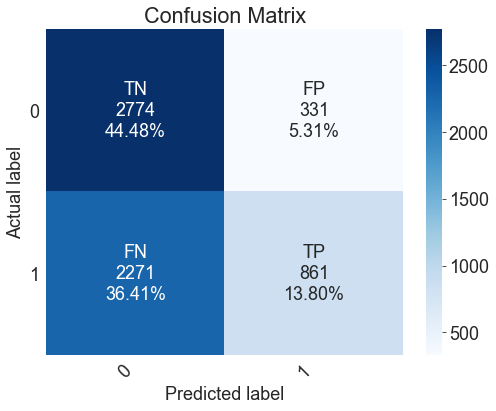

Cross Validation #8
Precision:  0.726144297905353
Sensitivity:  0.29952
Accuracy:  0.5924322590989257
F1 score:  0.4241051200724966


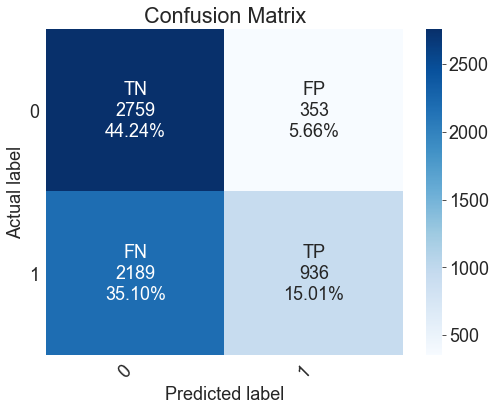

Cross Validation #9
Precision:  0.7132471728594507
Sensitivity:  0.28447164948453607
Accuracy:  0.5869809203142536
F1 score:  0.4067250115154306


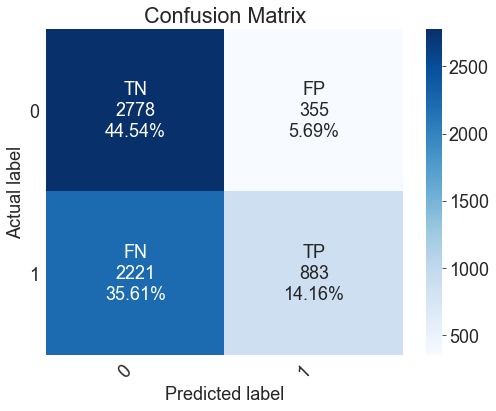

Cross Validation #10
Precision:  0.7225609756097561
Sensitivity:  0.3025853814235557
Accuracy:  0.5913099246432579
F1 score:  0.4265466816647919


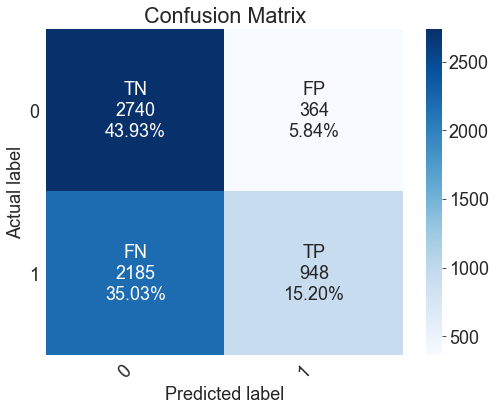

-------Testing-------
Precision:  0.710267229254571
Sensitivity:  0.286850326611758
Accuracy:  0.5782715336892224
F1 score:  0.4086587092858588


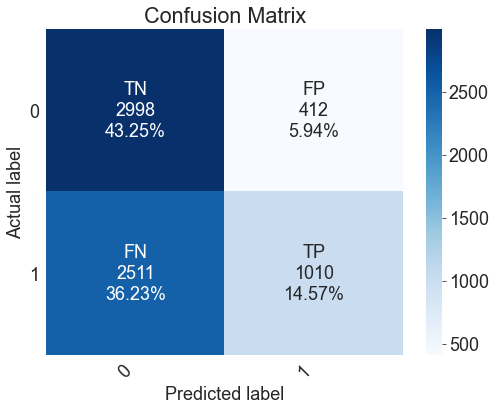

In [458]:
simulation_cross_validation.simulate(0.9, None, cross_validation=True, cross_validation_proportion=10)

-------Cross Validation-------
Cross Validation #1
Precision:  0.7005494505494505
Sensitivity:  0.3242212333121424
Accuracy:  0.5892914395639628
F1 score:  0.4432855280312908


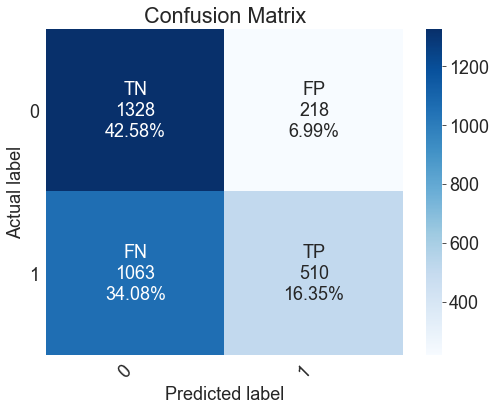

Cross Validation #2
Precision:  0.728110599078341
Sensitivity:  0.3046272493573265
Accuracy:  0.596344982366143
F1 score:  0.42954236520163114


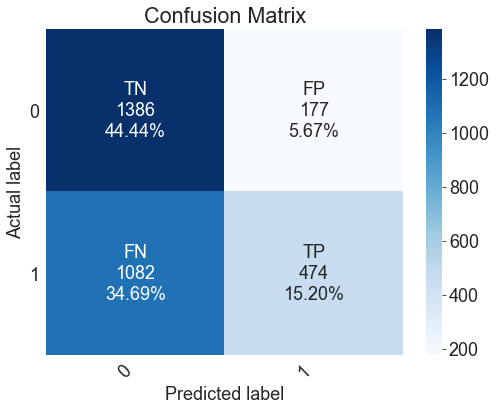

Cross Validation #3
Precision:  0.7293447293447294
Sensitivity:  0.3271565495207668
Accuracy:  0.6014748316768195
F1 score:  0.45169827966475523


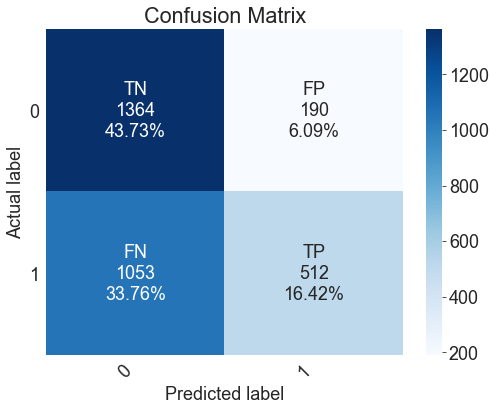

Cross Validation #4
Precision:  0.6971014492753623
Sensitivity:  0.31540983606557377
Accuracy:  0.5982686758576466
F1 score:  0.4343115124153499


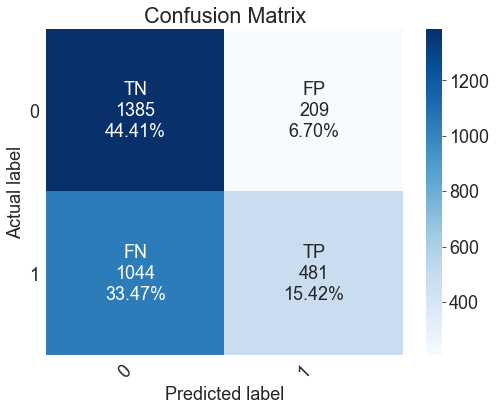

Cross Validation #5
Precision:  0.73568281938326
Sensitivity:  0.32012779552715653
Accuracy:  0.6011542160949022
F1 score:  0.446126447016919


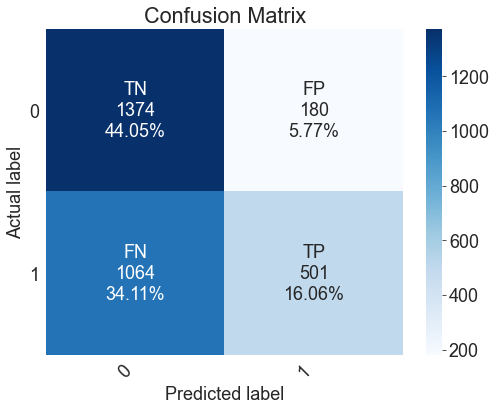

Cross Validation #6
Precision:  0.7072072072072072
Sensitivity:  0.3108910891089109
Accuracy:  0.6027572940044886
F1 score:  0.4319119669876204


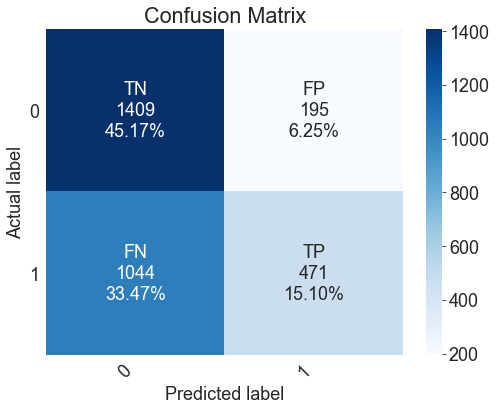

Cross Validation #7
Precision:  0.6876832844574781
Sensitivity:  0.30336351875808537
Accuracy:  0.5864058993267073
F1 score:  0.4210053859964093


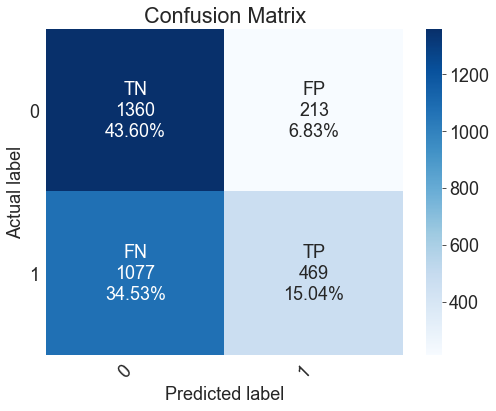

Cross Validation #8
Precision:  0.7155297532656023
Sensitivity:  0.31401273885350317
Accuracy:  0.5918563642193011
F1 score:  0.4364763169544046


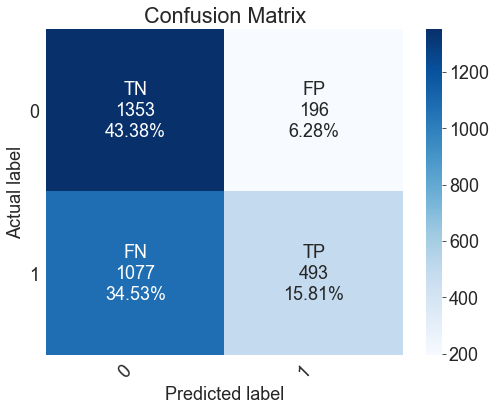

Cross Validation #9
Precision:  0.6961325966850829
Sensitivity:  0.32225063938618925
Accuracy:  0.5896120551458801
F1 score:  0.4405594405594406


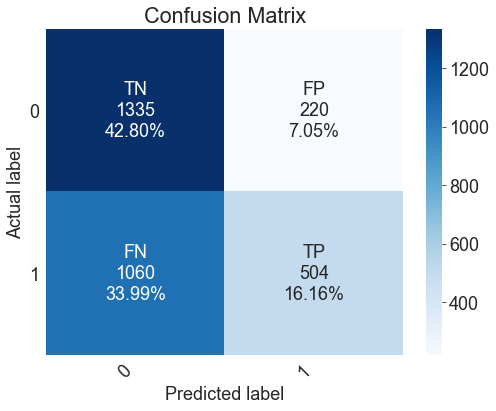

Cross Validation #10
Precision:  0.7191679049034175
Sensitivity:  0.3144899285250162
Accuracy:  0.6011542160949022
F1 score:  0.4376130198915009


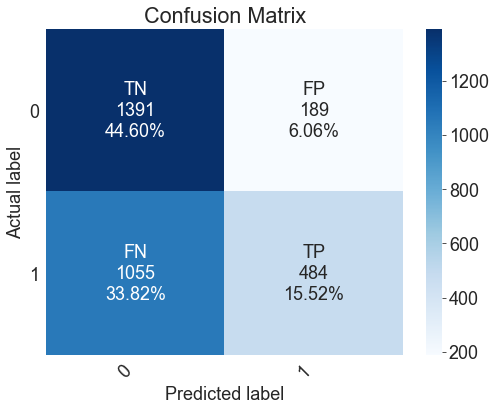

Cross Validation #11
Precision:  0.7203252032520325
Sensitivity:  0.2834293026231606
Accuracy:  0.5856318152661962
F1 score:  0.4067952249770432


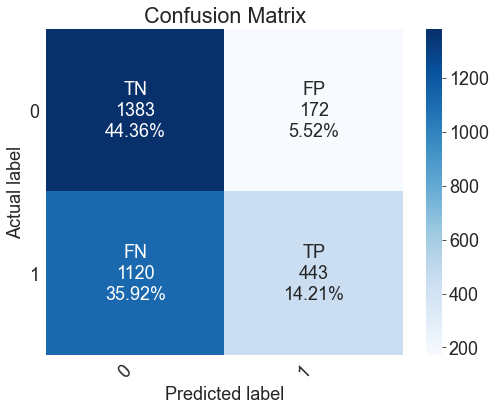

Cross Validation #12
Precision:  0.7252747252747253
Sensitivity:  0.3365200764818356
Accuracy:  0.6019884541372674
F1 score:  0.45973008271658683


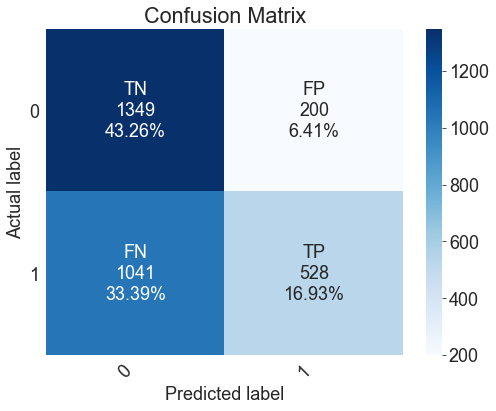

Cross Validation #13
Precision:  0.7296137339055794
Sensitivity:  0.32075471698113206
Accuracy:  0.5930083386786401
F1 score:  0.44560943643512446


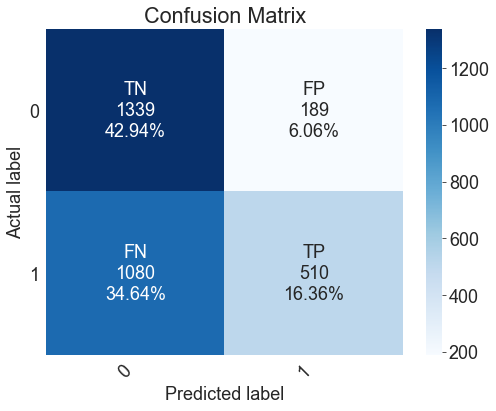

Cross Validation #14
Precision:  0.7443105756358769
Sensitivity:  0.3518987341772152
Accuracy:  0.6103271327774215
F1 score:  0.47786850021486893


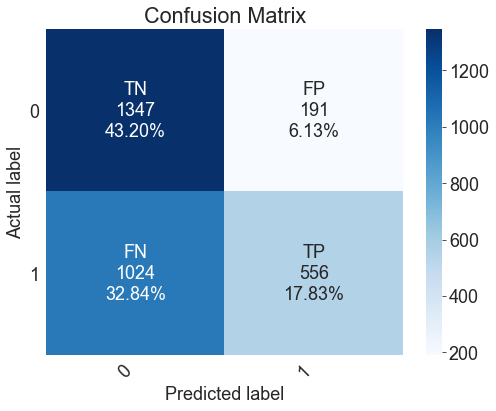

Cross Validation #15
Precision:  0.7087912087912088
Sensitivity:  0.3331181407359587
Accuracy:  0.6007055805003207
F1 score:  0.45322793148880103


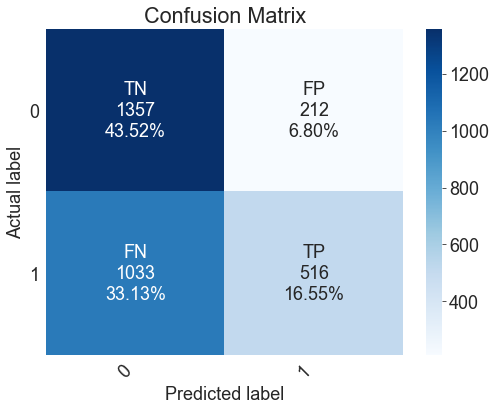

Cross Validation #16
Precision:  0.7265745007680492
Sensitivity:  0.30476804123711343
Accuracy:  0.5968569595894805
F1 score:  0.4294144348615525


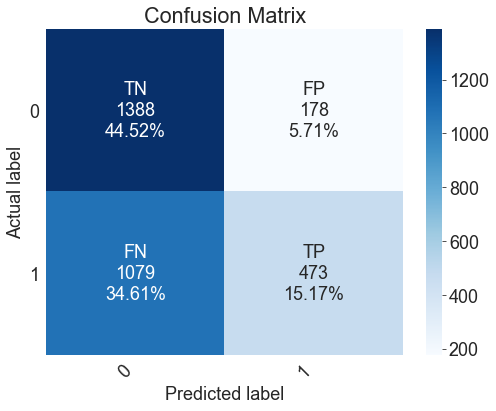

Cross Validation #17
Precision:  0.7162393162393162
Sensitivity:  0.27119741100323624
Accuracy:  0.5856318152661962
F1 score:  0.3934272300469484


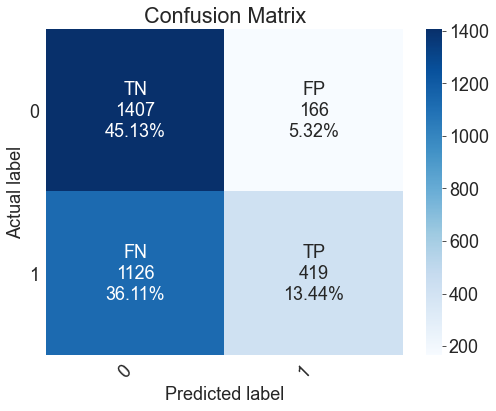

Cross Validation #18
Precision:  0.7256371814092953
Sensitivity:  0.30344827586206896
Accuracy:  0.584990378447723
F1 score:  0.42793987621573826


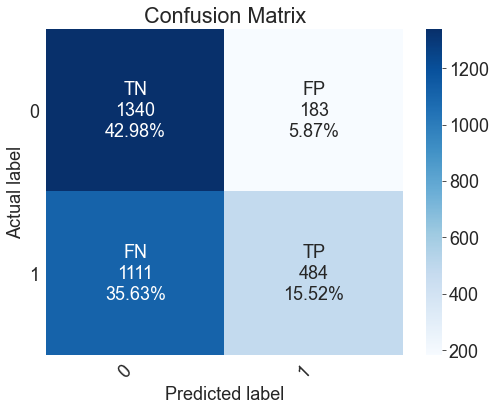

Cross Validation #19
Precision:  0.6931137724550899
Sensitivity:  0.3078457446808511
Accuracy:  0.600384862091084
F1 score:  0.4263351749539595


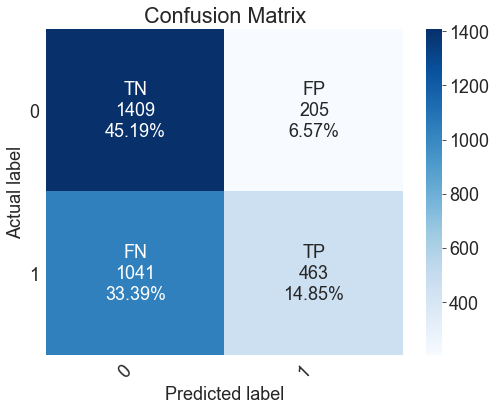

Cross Validation #20
Precision:  0.7309859154929578
Sensitivity:  0.32478097622027535
Accuracy:  0.5926876202694035
F1 score:  0.44974003466204504


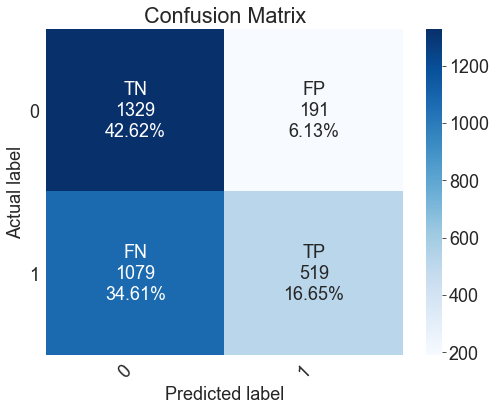

-------Testing-------
Precision:  0.7201413427561838
Sensitivity:  0.29459381324082107
Accuracy:  0.5908238349444525
F1 score:  0.4181370537546164


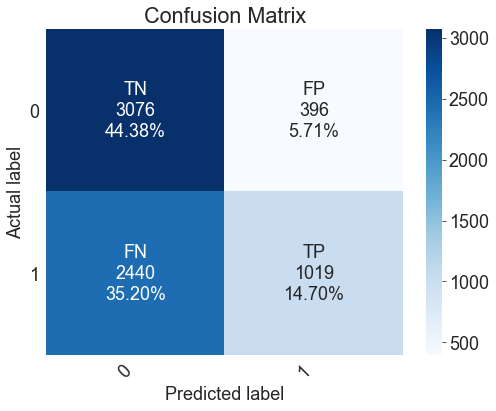

In [459]:
simulation_cross_validation.simulate(0.9, None, cross_validation=True, cross_validation_proportion=20)

In [460]:
simulation_cross_validation.get_simulation_table()

,action,train proportion,validation/cross validation proportion,test proportion,accuracy,precision,sensitivity,f1 score
0,Cross Validation,0.9,2,0.1,0.591342,0.722359,0.301619,0.423056
1,Testing,0.9,2,0.1,0.600058,0.728141,0.292072,0.416912
2,Cross Validation,0.9,5,0.1,0.590027,0.720732,0.290124,0.412955
3,Testing,0.9,5,0.1,0.582023,0.727734,0.285026,0.409619
4,Cross Validation,0.9,10,0.1,0.592224,0.721730,0.296907,0.420485
5,Testing,0.9,10,0.1,0.578272,0.710267,0.286850,0.408659
6,Cross Validation,0.9,20,0.1,0.595527,0.716869,0.314716,0.437131
7,Testing,0.9,20,0.1,0.590824,0.720141,0.294594,0.418137


In [461]:
simulation_cross_validation.sub_simulation_columns()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-447-ac2396cae44a>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  even_rows['accuracy'] = df['accuracy'].values[1::2] - df['accuracy'].values[::2]
<ipython-input-447-ac2396cae44a>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,train proportion,validation/cross validation proportion,test proportion,accuracy,precision,sensitivity,f1 score
0,0.9,2,0.1,0.008716,0.005782,-0.009547,-0.006144
2,0.9,5,0.1,-0.008004,0.007002,-0.005099,-0.003336
4,0.9,10,0.1,-0.013952,-0.011463,-0.010057,-0.011826
6,0.9,20,0.1,-0.004703,0.003273,-0.020122,-0.018994


Z tabelek powyżej otrzymałem, że średnio najlepszy wyniki są przy podziale zbioru trenującego na 5 części. W dalszej części wykorzystuję właśnie taki podział.
Następnie sprawdzam wpływ podziału zbiorów trenującego, testowego na działanie algorytmu.

-------Cross Validation-------
Cross Validation #1
Precision:  0.7294019238812213
Sensitivity:  0.27770700636942675
Accuracy:  0.5844957511624178
F1 score:  0.4022604082574098


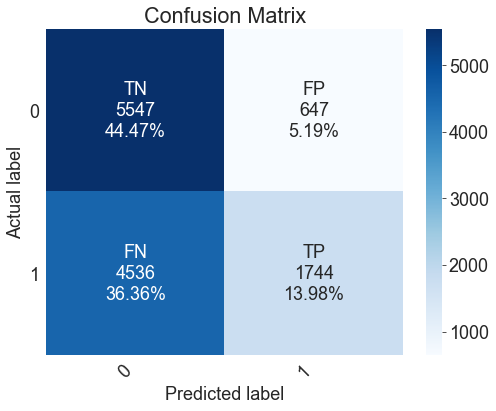

Cross Validation #2
Precision:  0.722702925422332
Sensitivity:  0.2842787682333874
Accuracy:  0.5920314253647587
F1 score:  0.4080493195300687


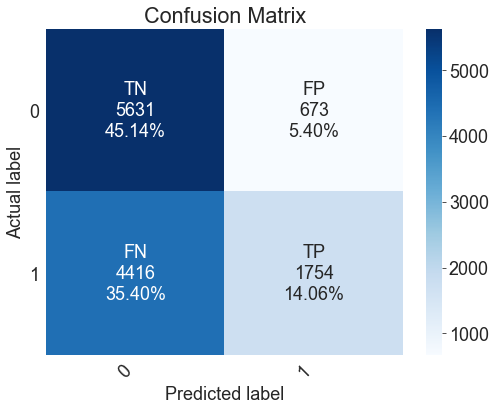

Cross Validation #3
Precision:  0.7179314976494291
Sensitivity:  0.33611067442226067
Accuracy:  0.5941157607824274
F1 score:  0.4578648677588607


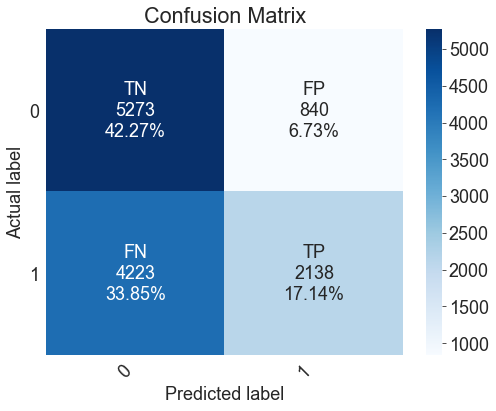

Cross Validation #4
Precision:  0.7228322605073836
Sensitivity:  0.3049520766773163
Accuracy:  0.5925124258457591
F1 score:  0.4289405684754522


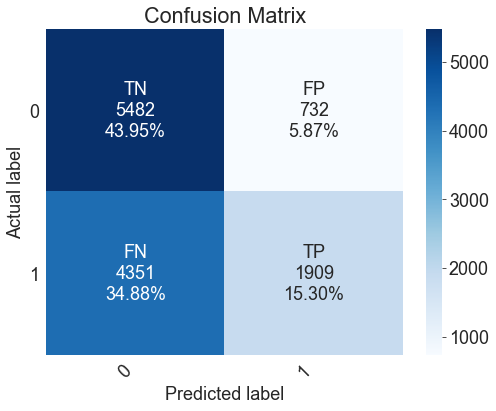

Cross Validation #5
Precision:  0.7161315583398591
Sensitivity:  0.3004764251683917
Accuracy:  0.6005291005291006
F1 score:  0.42333063302858465


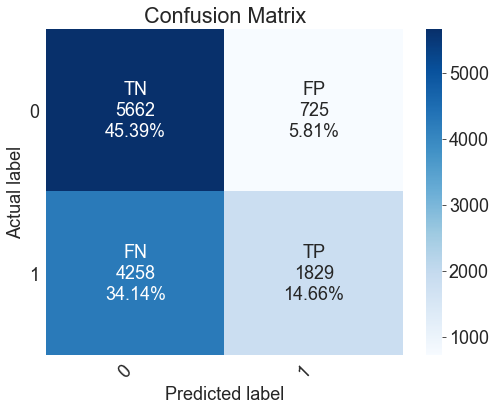

-------Testing-------
Precision:  0.714487632508834
Sensitivity:  0.2918591224018476
Accuracy:  0.5877939691242245
F1 score:  0.4144291863086698


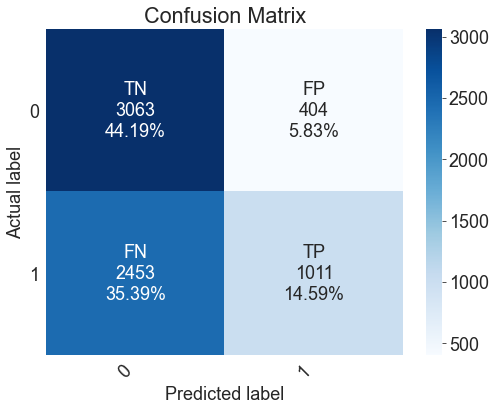

In [462]:
simulation_cross_validation_5 = Simulation(dataset)
simulation_cross_validation_5.simulate(0.9, None, cross_validation=True, cross_validation_proportion=5)

-------Cross Validation-------
Cross Validation #1
Precision:  0.7437562437562437
Sensitivity:  0.3051854888296782
Accuracy:  0.5977118119975263
F1 score:  0.4327859322772853


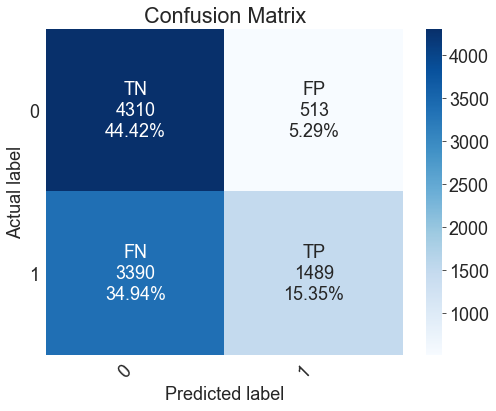

Cross Validation #2
Precision:  0.6860696517412935
Sensitivity:  0.2855072463768116
Accuracy:  0.5792620078334364
F1 score:  0.4032163742690058


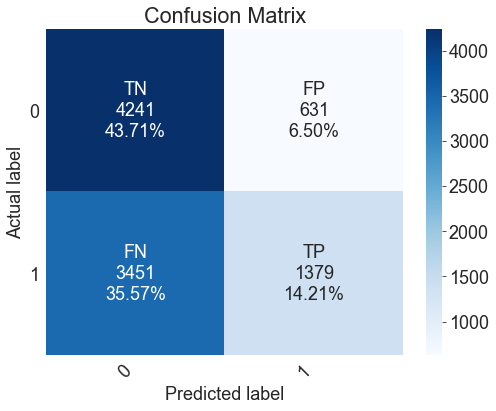

Cross Validation #3
Precision:  0.7167441860465116
Sensitivity:  0.3183226606073125
Accuracy:  0.5970933828076685
F1 score:  0.4408525246745816


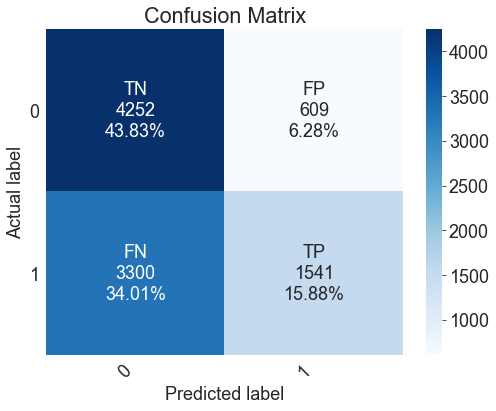

Cross Validation #4
Precision:  0.7040169133192389
Sensitivity:  0.2790113112693758
Accuracy:  0.5875077303648732
F1 score:  0.3996399639963996


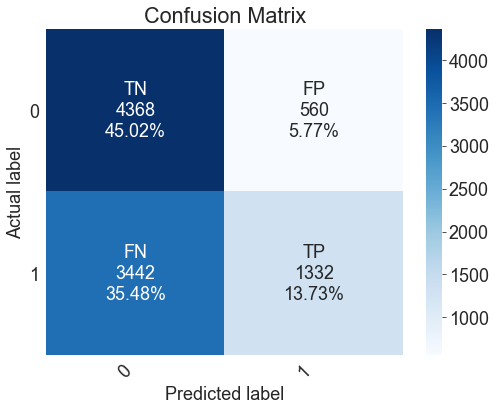

Cross Validation #5
Precision:  0.7191295546558705
Sensitivity:  0.29511941848390444
Accuracy:  0.5929705215419501
F1 score:  0.41849506700044176


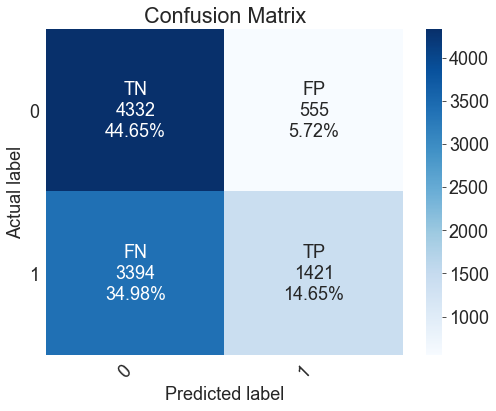

-------Testing-------
Precision:  0.7224199288256228
Sensitivity:  0.30983497090527523
Accuracy:  0.5919869174161897
F1 score:  0.4336738100006676


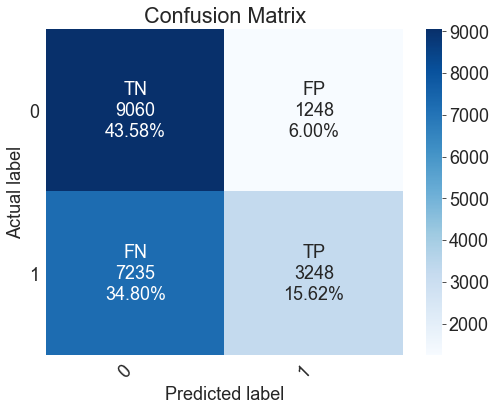

In [463]:
simulation_cross_validation_5.simulate(0.7, None, cross_validation=True, cross_validation_proportion=5)

-------Cross Validation-------
Cross Validation #1
Precision:  0.7775330396475771
Sensitivity:  0.257758305951077
Accuracy:  0.5968614718614719
F1 score:  0.3871675349602413


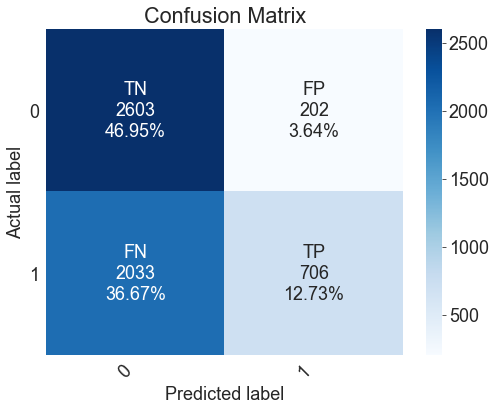

Cross Validation #2
Precision:  0.7716450216450217
Sensitivity:  0.2576797976147452
Accuracy:  0.5914502164502164
F1 score:  0.3863451639122189


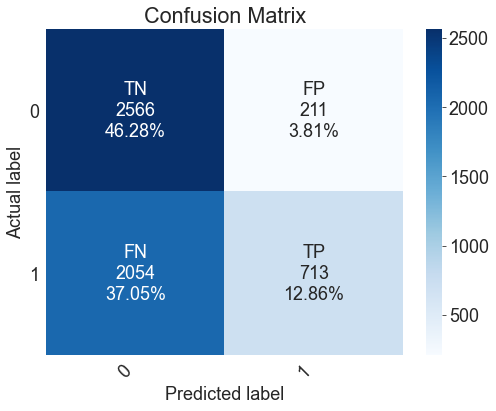

Cross Validation #3
Precision:  0.7845659163987139
Sensitivity:  0.25603357817418676
Accuracy:  0.5800865800865801
F1 score:  0.38607594936708856


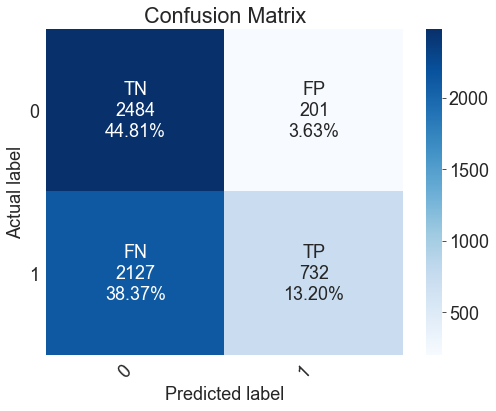

Cross Validation #4
Precision:  0.7677419354838709
Sensitivity:  0.25646551724137934
Accuracy:  0.5876623376623377
F1 score:  0.3844911147011309


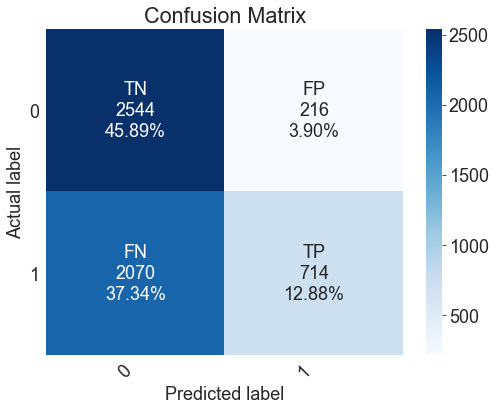

Cross Validation #5
Precision:  0.7691489361702127
Sensitivity:  0.26082251082251084
Accuracy:  0.5912698412698413
F1 score:  0.38954741379310354


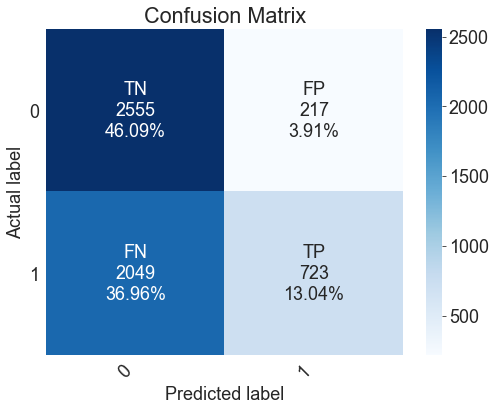

-------Testing-------
Precision:  0.7663130358959453
Sensitivity:  0.2547219941065649
Accuracy:  0.5902936437315119
F1 score:  0.382350808498296


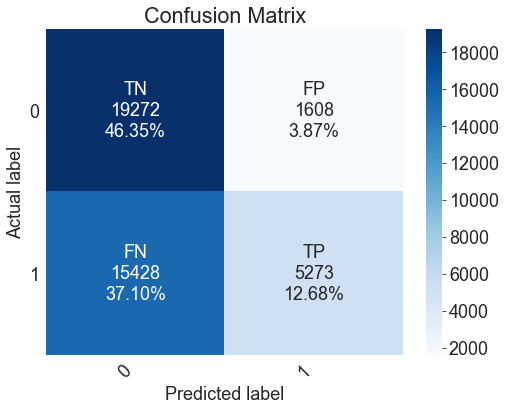

In [464]:
simulation_cross_validation_5.simulate(0.4, None, cross_validation=True, cross_validation_proportion=5)

-------Cross Validation-------
Cross Validation #1
Precision:  0.7057220708446866
Sensitivity:  0.38772455089820357
Accuracy:  0.626984126984127
F1 score:  0.5004830917874395


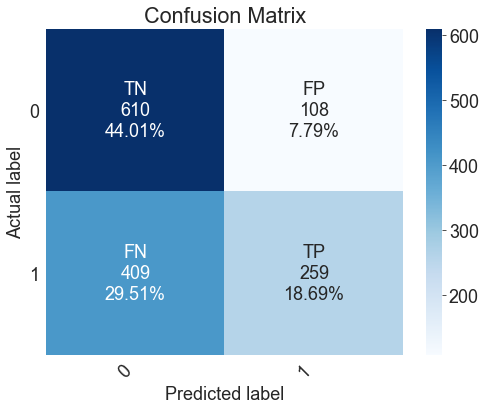

Cross Validation #2
Precision:  0.7327044025157232
Sensitivity:  0.34984984984984985
Accuracy:  0.6262626262626263
F1 score:  0.4735772357723577


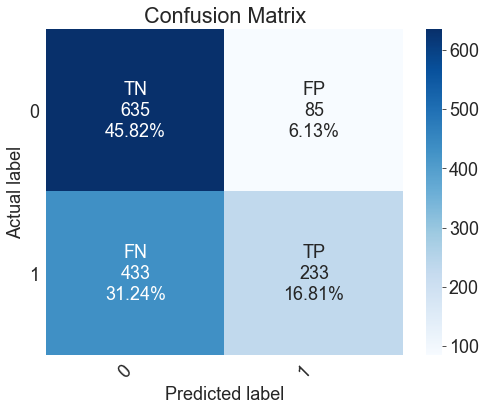

Cross Validation #3
Precision:  0.7068493150684931
Sensitivity:  0.3833580980683507
Accuracy:  0.6233766233766234
F1 score:  0.4971098265895954


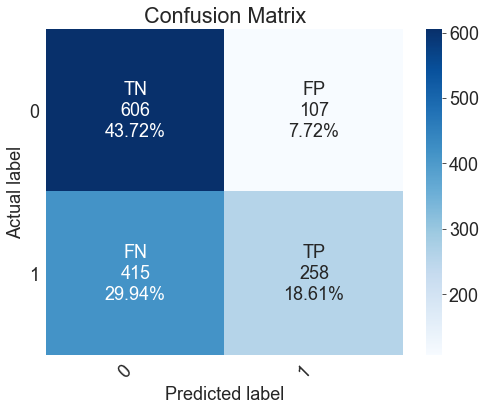

Cross Validation #4
Precision:  0.7121951219512195
Sensitivity:  0.41595441595441596
Accuracy:  0.6190476190476191
F1 score:  0.5251798561151079


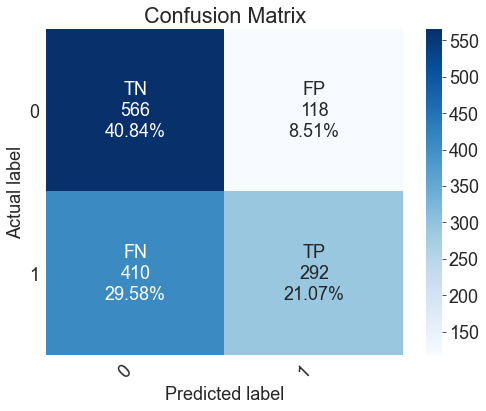

Cross Validation #5
Precision:  0.7702702702702703
Sensitivity:  0.2583081570996979
Accuracy:  0.6089466089466089
F1 score:  0.38687782805429866


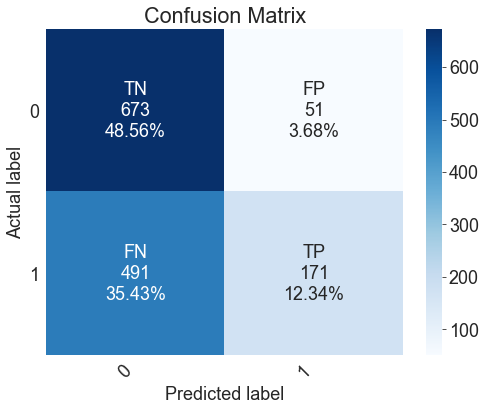

-------Testing-------
Precision:  0.7387883556254917
Sensitivity:  0.36056446193721803
Accuracy:  0.6157348767856856
F1 score:  0.4846138958776854


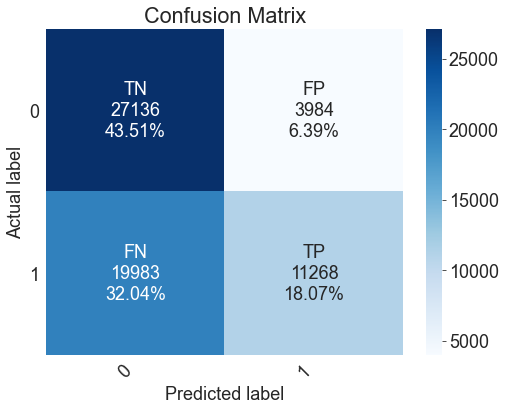

In [465]:
simulation_cross_validation_5.simulate(0.1, None, cross_validation=True, cross_validation_proportion=5)

Po kilkokrotnej symulacji otrzymałem podobne wyniki jak w przypadku zwykłej walidacji. Na przykład po zmianie podziału zbiorów nie widać było czy większy czy mniejszy zbiór trenujący daje lepszy wynik. W przypadku jak większego tak i mniejszego zbioru trenującego otrzymywałem raz, że lepszy wynik daje trenowanie na dużym zbiorze, a raz, że na mniejszym. Natomiast zauważyłem, że w przypadku mniejszego zbioru miałem do czynienie z większym rozrzuceniem wartości F1 (od 0,35 do 0,49)

In [466]:
simulation_cross_validation_5.get_simulation_table()

,action,train proportion,validation/cross validation proportion,test proportion,accuracy,precision,sensitivity,f1 score
0,Cross Validation,0.9,5,0.1,0.592737,0.721800,0.300705,0.424089
1,Testing,0.9,5,0.1,0.587794,0.714488,0.291859,0.414429
2,Cross Validation,0.7,5,0.3,0.590909,0.713943,0.296629,0.418998
3,Testing,0.7,5,0.3,0.591987,0.722420,0.309835,0.433674
4,Cross Validation,0.4,5,0.6,0.589466,0.774127,0.257752,0.386725
5,Testing,0.4,5,0.6,0.590294,0.766313,0.254722,0.382351
6,Cross Validation,0.1,5,0.9,0.620924,0.725548,0.359039,0.476646
7,Testing,0.1,5,0.9,0.615735,0.738788,0.360564,0.484614


In [467]:
simulation_cross_validation_5.sub_simulation_columns()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-447-ac2396cae44a>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  even_rows['accuracy'] = df['accuracy'].values[1::2] - df['accuracy'].values[::2]
<ipython-input-447-ac2396cae44a>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,train proportion,validation/cross validation proportion,test proportion,accuracy,precision,sensitivity,f1 score
0,0.9,5,0.1,-0.004943,-0.007312,-0.008846,-0.009660
2,0.7,5,0.3,0.001078,0.008477,0.013206,0.014676
4,0.4,5,0.6,0.000828,-0.007814,-0.003030,-0.004375
6,0.1,5,0.9,-0.005189,0.013240,0.001525,0.007968


## Porównanie walidacji krzyżowej i zwykłej

In [470]:
simulation_cross_validation_5.get_simulation_table()

,action,train proportion,validation/cross validation proportion,test proportion,accuracy,precision,sensitivity,f1 score
0,Cross Validation,0.9,5,0.1,0.592737,0.721800,0.300705,0.424089
1,Testing,0.9,5,0.1,0.587794,0.714488,0.291859,0.414429
2,Cross Validation,0.7,5,0.3,0.590909,0.713943,0.296629,0.418998
3,Testing,0.7,5,0.3,0.591987,0.722420,0.309835,0.433674
4,Cross Validation,0.4,5,0.6,0.589466,0.774127,0.257752,0.386725
5,Testing,0.4,5,0.6,0.590294,0.766313,0.254722,0.382351
6,Cross Validation,0.1,5,0.9,0.620924,0.725548,0.359039,0.476646
7,Testing,0.1,5,0.9,0.615735,0.738788,0.360564,0.484614


In [471]:
simulation_simple_validation.get_simulation_table()

,action,train proportion,validation/cross validation proportion,test proportion,accuracy,precision,sensitivity,f1 score
0,Validation,0.81,0.09,0.10,0.589546,0.729286,0.285027,0.409866
1,Testing,0.81,0.09,0.10,0.583898,0.718228,0.283788,0.406828
2,Validation,0.63,0.27,0.10,0.587141,0.714591,0.286572,0.409087
3,Testing,0.63,0.27,0.10,0.595729,0.733045,0.294664,0.420356
4,Validation,0.45,0.45,0.10,0.579926,0.724835,0.247917,0.369465
5,Testing,0.45,0.45,0.10,0.582167,0.758383,0.252216,0.378541
6,Validation,0.33,0.33,0.34,0.630460,0.668075,0.513471,0.580658
7,Testing,0.33,0.33,0.34,0.637864,0.680004,0.521798,0.590488
8,Validation,0.25,0.25,0.50,0.594170,0.732457,0.285631,0.410991
9,Testing,0.25,0.25,0.50,0.589045,0.722851,0.287637,0.411522


In [468]:
simulation_cross_validation_5.sub_simulation_columns()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-447-ac2396cae44a>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  even_rows['accuracy'] = df['accuracy'].values[1::2] - df['accuracy'].values[::2]
<ipython-input-447-ac2396cae44a>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,train proportion,validation/cross validation proportion,test proportion,accuracy,precision,sensitivity,f1 score
0,0.9,5,0.1,-0.004943,-0.007312,-0.008846,-0.009660
2,0.7,5,0.3,0.001078,0.008477,0.013206,0.014676
4,0.4,5,0.6,0.000828,-0.007814,-0.003030,-0.004375
6,0.1,5,0.9,-0.005189,0.013240,0.001525,0.007968


In [469]:
simulation_simple_validation.sub_simulation_columns()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-447-ac2396cae44a>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  even_rows['accuracy'] = df['accuracy'].values[1::2] - df['accuracy'].values[::2]
<ipython-input-447-ac2396cae44a>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,train proportion,validation/cross validation proportion,test proportion,accuracy,precision,sensitivity,f1 score
0,0.81,0.09,0.10,-0.005648,-0.011058,-0.001240,-0.003038
2,0.63,0.27,0.10,0.008588,0.018454,0.008092,0.011268
4,0.45,0.45,0.10,0.002241,0.033549,0.004299,0.009076
6,0.33,0.33,0.34,0.007404,0.011930,0.008327,0.009830
8,0.25,0.25,0.50,-0.005125,-0.009606,0.002006,0.000531
10,0.08,0.32,0.60,-0.001097,-0.008126,0.006690,0.004847


Porównując różnice pomiędzy wynikami uzyskanych na zbiorach walidacyjnych i testowych z wykorzystaniem walidacji krzyżowej oraz zwykłej możemy wywnioskować, że dla wartości F1 ta różnica w obu przypadkach minimalnie się różni. Natomiast w przypadku dokładności otrzymałem, że z walidacją krzyżową, ta różnica jest mniejsza od różnicy w przypadku symulacji z wykorzystaniem walidacji zwykłej.

# Wnioski

Analizując otrzymane powyżej wyniki, można powiedzieć, że dla danych zbiorów danych naiwny klasyfikator Bayesa (wyniki F1 są od 0,25 do 0,62) daje gorsze wyniki w porównaniu do algorytmu ID3 (wyniki F1 są od 0.64  do 0.66) zaimplementowanego na 4 ćwiczeniach, natomiast szybkość uczenia jest znaczniej większa.
Wynik oraz jakość działania naiwnego klasyfikatora Bayesa minimalnie zależy od podziału danych na zbiory trenujący, walidacyjny oraz testowy w przypadku z wykorzystaniem walidacji krzyżowej oraz zwykłej. Porównując działanie walidacji krzyżowej oraz walidacji zwykłej zauważyłem, że walidacja krzyżowa jest minimalnie lepsza od walidacji zwykłej pod względem różnicy pomiędzy dokładnością uzyskanej na zbiorach walidacyjnych i testowych.